## Driving mechanisms of sea ice breakup - Changes in ice properties

In [6]:
%matplotlib inline
import sys
sys.path.append('../src')
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from pynextsim.projection_info import ProjectionInfo
from brkup_utils import lead_detect as lead_det
from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils.boxnames import *
from brkup_utils.calc_deformation_NANUK import calc_deformation_rate
from brkup_utils import grid_funcs as grd

In [7]:
# read moorings 
indir = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    

months = ['01', '02', '03']
years = list(range(2000, 2018+1))
region='Beaufort'

# subset Beaufort Sea
ds = process_data.load_moorings(indir,months,years,region='Beaufort',period=None)

# daily average
# set all dates to have time at 00h so multiple measurements in a day have the same label
ds.coords['time'] = ds.time.dt.floor('1D')
ds = ds.groupby('time').mean()

# create masks
bbox = BOXNAMES[region]
Mask = msk.Masking(ds, bbox=bbox)
msk_moore22 = Mask.get_Moore2022_Beaufort_mask()

# get area info from model grid and add to dataset
creg_grid = grd.CREGgrid('../grid_files', bbox)
ds['mod_area'] = (('y','x'), creg_grid.get_area())
ds['mod_area'].attrs = {'units':'m2', 'long_name':'grid_cell_area'}


months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!


### Calculate ice deformation

In [8]:
# get deltax and deltay from native grid
creg_grid_file = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-I/mesh_mask_NANUK025_3.6.nc'
creg_grid = xr.open_dataset(creg_grid_file)

# select beaufort region
creg_grid = process_data.subset_data_region(creg_grid, region='Beaufort')

dx = creg_grid.e1u.values
dy = creg_grid.e1v.values
uv = [ds.siu, ds.siv] 

shear, div, deform = calc_deformation_rate(uv, dx, dy, dt=24*60*60, x_dim=-1, y_dim=-2)

ds['shear'] = (('time','y','x'), shear)
ds['div'] = (('time','y','x'), div)
ds['deform'] = (('time','y','x'), deform)

ds.shear.attrs = dict(        
        long_name="Shear", 
        units="1/day",
    )

ds.div.attrs = dict(        
        long_name="Divergence", 
        units="1/day",
    )

ds.deform.attrs = dict(        
        long_name="Total deformation", 
        units="1/day",
    )

bbox for Beaufort : (95, 225, 425, 575)


### Calculate mean values for Beaufort region

In [9]:
# mean damage 
damage = ds['damage'].where(msk_moore22).mean(dim=('x', 'y'))
damage_JFM = damage.groupby('time.year').mean()

# deformation
deformation = ds['deform'].where(msk_moore22).mean(dim=('x', 'y'))

# Ice velocity
ds['ice_speed'] = (ds['siu']**2 + ds['siv']**2)**0.5
ds['ice_speed'] = ds['ice_speed']*1E2 # in cm/s 
ds.ice_speed.attrs["units"] = "cm s-1" 

icevel_mean = ds['ice_speed'].where(msk_moore22).mean(dim=('x', 'y'))

# Wind speed to ice speed ratio
ds['wspeed'] = (ds['wndx']**2 + ds['wndy']**2)**0.5
wspeed_BSmean = ds['wspeed'].where(msk_moore22).mean(dim=('x', 'y'))

icewind_ratio = (icevel_mean*1E-2) / wspeed_BSmean # both in m/s


# Plot Figure 5

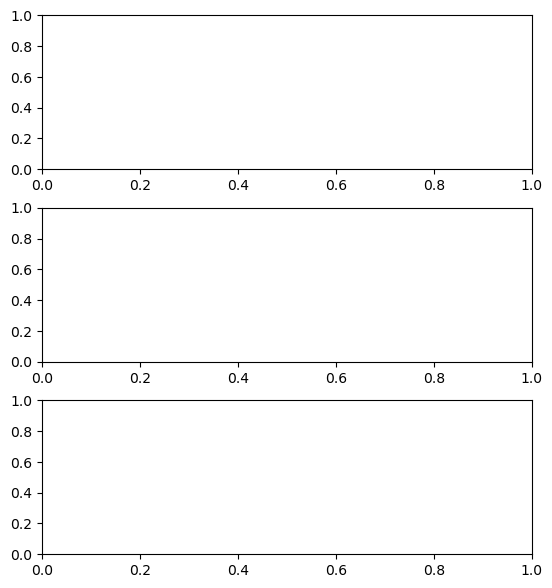

In [16]:
fig = plt.figure(figsize=(5,7), constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=1, left=0.01, right=0.99, wspace=0.3, hspace=0.25)

#-- ice speed
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,:])

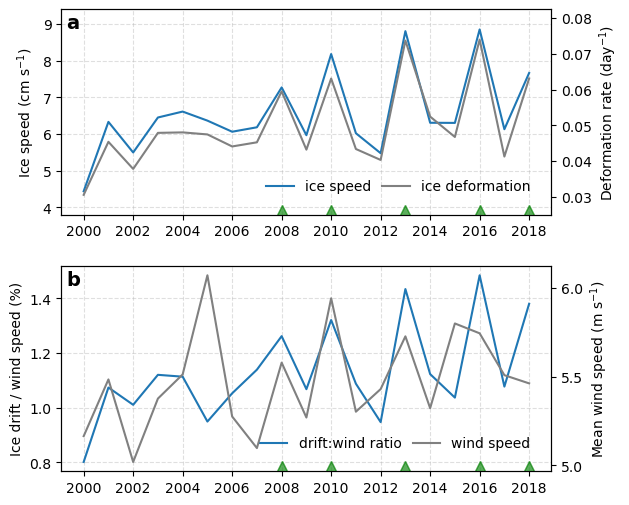

In [28]:
fig = plt.figure(figsize=(5,6), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=1, left=0.01, right=0.99, wspace=0.3, hspace=0.25)

kw1={'alpha': 1, 'linewidth':1.5}
kw = {'marker':'o', 'markersize':5, 'markeredgecolor':'C0', 'markerfacecolor':(0,0,0,0.4)}

x = ds.groupby('time.year').mean('time').year
cmap = plt.cm.winter(np.linspace(0,1,3))

#-- ice speed
ax1 = fig.add_subplot(gs[0,:])
icevel_meanJFM = icevel_mean.groupby('time.year').mean('time')
l1 = ax1.plot(x, icevel_meanJFM,  **kw1, label='ice speed')
ax1.set_ylabel('Ice speed (cm s$^{-1}$)')
ax1.set_ylim([3.8, 9.4])
ax1.grid(ls='--', alpha=0.4)

#-- deformation
ax2 = ax1.twinx()
#ax2 = fig.add_subplot(gs[1,:])
deform_JFM = deformation.groupby('time.year').mean('time')
l2 = ax2.plot(x, deform_JFM, **kw1, color='grey', ls='-', label='ice deformation')
ax2.set_ylabel('Deformation rate (day$^{-1}$)')
ax2.set_ylim([0.025, 0.0825])
#ax2.grid(ls='--', alpha=0.4)

# added these three lines
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right', ncols=2, frameon=False, borderpad=1,columnspacing=0.8,handlelength=2)

#-- ratio
#ax3 = fig.add_subplot(gs[2,:])
ax3 = fig.add_subplot(gs[1,:])
icewind_ratio_JFM = icewind_ratio.groupby('time.year').mean('time')*100

l1=ax3.plot(x, icewind_ratio_JFM, **kw1, label='drift:wind ratio')
ax3.set_ylabel('Ice drift / wind speed (%)')
ax3.grid(ls='--', alpha=0.4)

ax3r = ax3.twinx()
wspeed_meanJFM = wspeed_BSmean.groupby('time.year').mean('time')
l2 = ax3r.plot(x, wspeed_meanJFM, lw=1.5, color='grey', ls='-', label='wind speed' )
ax3r.set_ylabel('Mean wind speed (m s$^{-1}$)')
ax3r.set_yticks([5.0, 5.5, 6.0])

# added these three lines
lns = l1+l2
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='lower right', ncols=2,frameon=False, borderpad=1,columnspacing=0.8, handlelength=2)

# add figure labels
#axes = (ax1,ax2,ax3)
#labels = ['a', 'b', 'c']
axes = (ax1,ax3)
labels = ['a', 'b']

# highlight breakup years
id_yrs = x[x.isin([2008, 2010, 2013, 2016, 2018])]
cbargs = {'color': 'green', 'alpha': 0.4, 'zorder':3, 'marker':"^", 'markersize': 15, 'ymax':0.}

for ax, lab in zip(axes, labels):
    ax.text(0.01, 0.98, lab, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top')
    ax.set_xticks(np.arange(2000,2018+2,2))
    [ax.axvline(dto, **cbargs) for dto in id_yrs]

plt.show()

fig.savefig('../figures/' + f'fig05_iceSpeed_deformation_windFactor_moore22_JFM_2000-2018_v2.png', dpi=300, bbox_inches='tight')


## Plot deformation maps

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

sic_plotargs = {'vmin':60, 'vmax':100, 'cmap': cmocean.cm.ice, 'label':"SIC (%)"}
shear_plotargs = {'vmin':0, 'vmax':1.5, 'cmap': cmocean.cm.thermal, 'label': "Shear (day$^{-1}$)"}
div_plotargs =  {'vmin':-0.1, 'vmax':0.1, 'cmap': cmocean.cm.balance, 'label': "Divergence (day$^{-1}$)"}

plotargs = [sic_plotargs, shear_plotargs, div_plotargs]

fig, axs= plt.subplots(1,3, figsize=(15,10))

cmap = [cmocean.cm.ice_r,  cmocean.cm.balance,  cmocean.cm.thermal] 
date = '2018-03-20'
for i, var in enumerate([ds['sic']*100, ds.shear, ds.div]): 

    var = var.sel(time=date)
    im=axs[i].imshow(var, **plotargs[i] )
    
    cax = inset_axes(axs[i],
                 width="5%",  # width = 50% of parent_bbox width
                 height="100%",  # height : 5%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=axs[i].transAxes,
                 borderpad=0)
    
    clabel = plotargs[i]['label']
    plt.colorbar(im, cax=cax, label=clabel)
    axs[i].set_title(clabel+ f' {date}')

fig.subplots_adjust(bottom=0.01, top=0.98, left=0.02, right=0.86, wspace=0.45, hspace=0.02)
plt.show()